# Vinfast car classification 🚗

In [ ]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

%pip install opencv-python-headless

!pip install console_progressbar

In [ ]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
import torch
from torch import nn
from pathlib import Path
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

import numpy as np
import torch.nn.functional as F
import os
from torchvision import datasets, transforms, models
import tarfile
import scipy.io
import cv2 as cv
import random
import re
import csv
from console_progressbar import ProgressBar


## Load datasets from my drive

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
with zipfile.ZipFile('/content/drive/My Drive/Datasets/datasets-car.zip', 'r') as zip_ref:
    zip_ref.extractall('datasets')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Datasets/datasets-car.zip", 'r')
zip_ref.extractall("/datasets")
zip_ref.close()

## Prepare dataset

In [ ]:
cars_training_path = Path('/content/datasets/cars_test')
cars_testing_path = Path('/content/datasets/cars_train')


## Init Dataset and Split into Training and Validation Sets


In [ ]:
ds = ImageFolder(cars_training_path)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Show Some Examples

#### ⚠️ Note - Because I prepare the datasets myself so the image isn't perfect ⚠️


A few bad images is OK, but if they are completely incorrect you'll definitely want to try again with different terms.

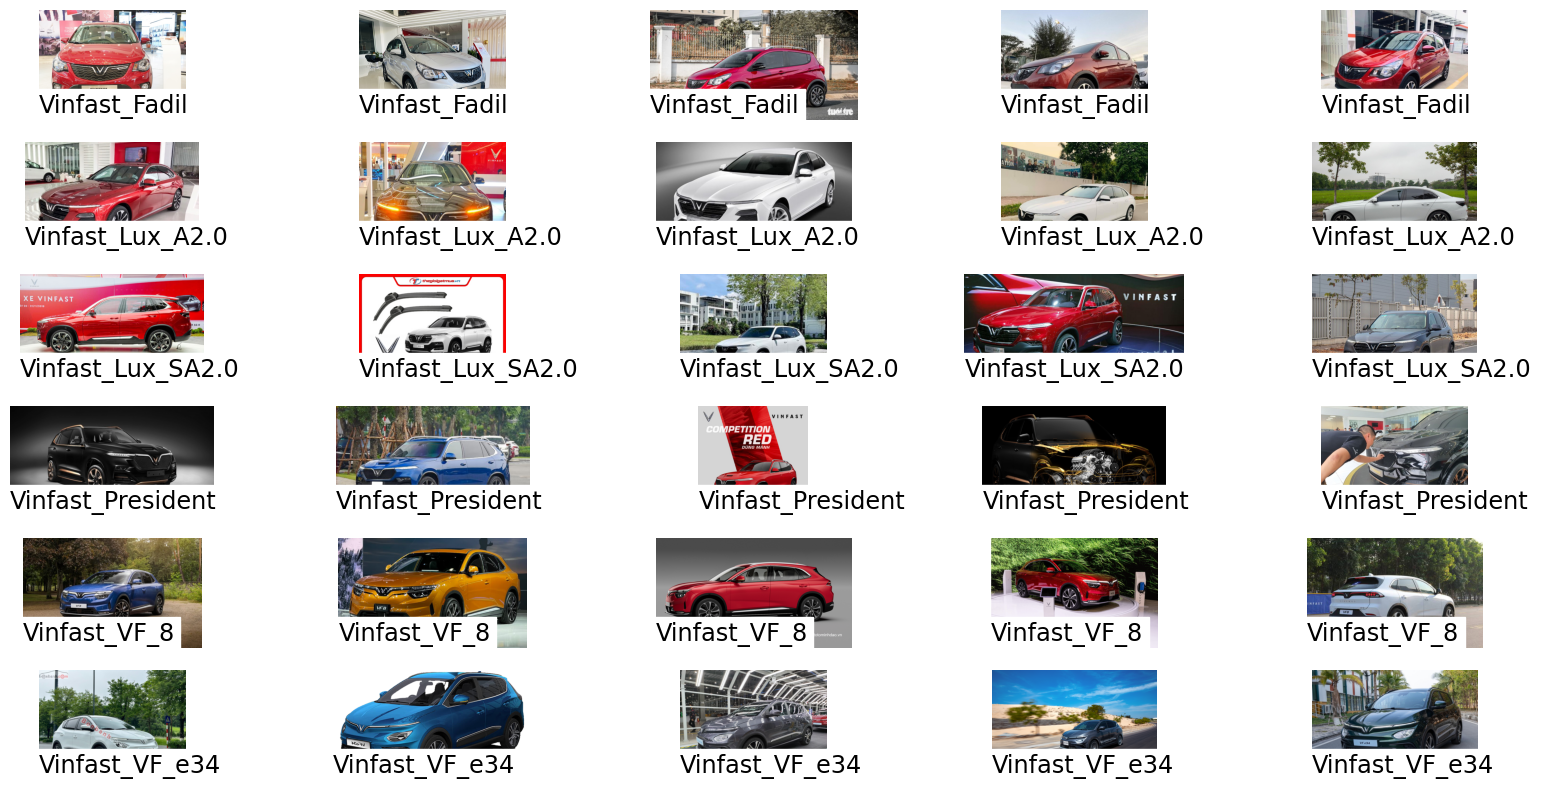

In [ ]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [ ]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name
print(f'len(label2id)={len(label2id)}, len(id2label) = {len(id2label)}')

len(label2id)=6, len(id2label) = 6


## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Init Feature Extractor, Model, Data Loaders

I using a pre-model [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) for feature extraction to save time.

There are significant benefits to [using a pretrained model](https://huggingface.co/docs/transformers/training). It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch.Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique. In this tutorial, you will fine-tune a pretrained model with a deep learning framework of your choice:

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')

device = cuda:0


In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Multiclass

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


## Check if it Worked

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([3, 2, 0, 1, 4, 0, 2, 3])
Labels: tensor([3, 5, 1, 1, 4, 0, 2, 3])


In [ ]:
def find_mismatch(preds, original_labels, mismatch_output_list, mismatch_dict):
  for pred, label in zip(preds, original_labels):
    if pred != label:
      mismatch_dict[label].append(pred)
      mismatch_output_list.append([label, pred])
  return mismatch_output_list, mismatch_dict

In [ ]:
from collections import defaultdict

validation_ds = ImageFolder(cars_testing_path)
val_ds = torch.utils.data.Subset(ds, indices[:])
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)
val_batch = next(iter(val_loader))
mismatch_output_list = []
mismatch_dict = defaultdict(list)
y_true = []
y_pred = []

for val_batch in val_loader:
  outputs = model(**val_batch)
  preds = outputs.logits.softmax(1).argmax(1)
  original_labels = val_batch['labels']
  y_true += original_labels
  y_pred += preds
  find_mismatch(preds, original_labels, mismatch_output_list, mismatch_dict)
  #print('Preds: ', outputs.logits.softmax(1).argmax(1))
  #print('Labels:', val_batch['labels'])

print(f'len(mismatch_output_list)={len(mismatch_output_list)}')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


len(mismatch_output_list)=5


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
# plt.figure(figsize=(1200,1200))
# plt.show(display.plot)
# print(classification_report(y_true, y_pred))

# import pandas as pd
# import seaborn as sns
# confusion_matrix_df = pd.DataFrame(display.confusion_matrix)
# sns.heatmap(confusion_matrix_df, annot=True)


correct = accuracy_score(y_true, y_pred)
print('accuracy score:', correct)

AttributeError: ignored

Error in callback <function _draw_all_if_interactive at 0x7e24892c2a70> (for post_execute):


ValueError: ignored

<Figure size 120000x120000 with 0 Axes>

## Check result of model

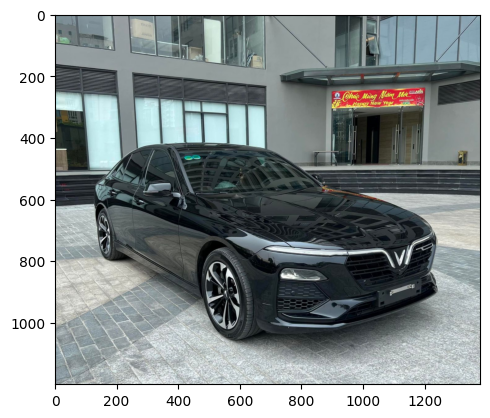

In [ ]:
import PIL.ImageOps
import requests
from PIL import Image


url = 'https://tieudung.kinhtedothi.vn/upload_images/images/2022/05/03/gi%C3%A1%20xe.jpg'
img = Image.open(requests.get(url, stream=True).raw)
plt.imshow(img)

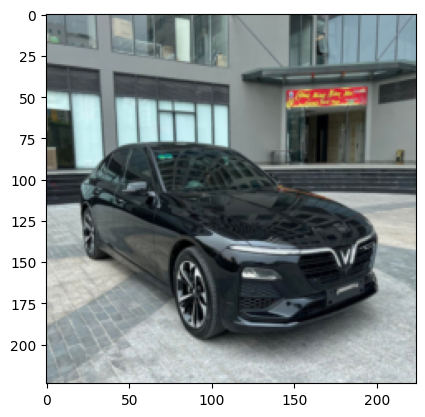

In [ ]:
# Create the validation data transform object for augmenting the image and resizing the image to fit into an existing pre-trained model.
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
# Define a function to transpose the image.
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
image = img.unsqueeze(0)
output = model(image)
preds = output.logits.softmax(1).argmax(1)

In [ ]:
# The probabilities are the softmax() of the predictions

class_prob = torch.softmax(output.logits, dim=1)
# get most probable class and its probability:
class_prob, topclass = torch.max(output.logits.softmax(1), dim=1)

score_probabilities = ''.join(map(str, class_prob.detach().numpy()))
preds_string = ''.join(map(str, topclass.numpy()))

print(f"pred:{preds_string}, score: {score_probabilities}, original_label :{list(label2id.keys())[list(label2id.values()).index(preds_string)]}")

pred:1, score: 0.21569411, original_label :Vinfast_Lux_A2.0


## Saved model

In [ ]:
torch.save(model.state_dict(), "vinfast_model.pth")

## Upload to huggingface_hub ✔

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login

In [ ]:
notebook_login()

In [ ]:
model_id = "vinfast-car-classifier" #@param {type:"string"}

description = """
Autogenerated by HuggingPics🤗🖼️

Create your own image classifier for **anything** by running [the demo on Google Colab](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb).

Report any issues with the demo at the [github repo](https://github.com/nateraw/huggingpics).
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

Cloning https://huggingface.co/hungtu/vinfast-car-classifier into local empty directory.
Adding files tracked by Git LFS: ['images/Vinfast_Fadil.jpeg', 'images/Vinfast_Lux_A2.0.jpeg', 'images/Vinfast_Lux_SA2.0.jpeg', 'images/Vinfast_President.jpeg', 'images/Vinfast_VF_8.jpeg', 'images/Vinfast_VF_e34.jpeg']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file images/Vinfast_Lux_SA2.0.jpeg:   0%|          | 1.00/153k [00:00<?, ?B/s]

Upload file images/Vinfast_VF_8.jpeg:   0%|          | 1.00/222k [00:00<?, ?B/s]

Upload file images/Vinfast_Lux_A2.0.jpeg:   0%|          | 1.00/93.5k [00:00<?, ?B/s]

Upload file images/Vinfast_President.jpeg:   0%|          | 1.00/45.0k [00:00<?, ?B/s]

Upload file images/Vinfast_Fadil.jpeg:   0%|          | 1.00/934k [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1690892069.3bce5b6ce63f.599.0:   0%|          | 1.00/1.00k [00:00<?, ?B/s…

Upload file images/Vinfast_VF_e34.jpeg:   0%|          | 1.00/91.7k [00:00<?, ?B/s]

To https://huggingface.co/hungtu/vinfast-car-classifier
   73b862d..6c8a416  main -> main

   73b862d..6c8a416  main -> main



Check out your model at:
https://huggingface.co/hungtu/vinfast-car-classifier
